<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/QA_DQVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jan  7 03:19:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%time
!tar -xf /content/drive/MyDrive/Colab\ Notebooks/Final-project/train.tar.gz 
!tar -xf /content/drive/MyDrive/Colab\ Notebooks/Final-project/val.tar.gz 
!tar -xf /content/drive/MyDrive/Colab\ Notebooks/Final-project/test.tar.gz

CPU times: user 414 ms, sys: 79.3 ms, total: 494 ms
Wall time: 3min 27s


In [3]:
!pip install -q "transformers<4.0.0"

     |████████████████████████████████| 1.3MB 15.3MB/s 
     |████████████████████████████████| 1.1MB 55.9MB/s 
     |████████████████████████████████| 2.9MB 52.7MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 


In [4]:
# Python / Básics
import os
import gc
import glob
import time
import json
import random
import logging
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

# PIL 
from PIL import Image

# Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split


# Transformers / Sentence Transformers
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [5]:
# ==================================== #
# === Função que carregas as seeds === #
# ==================================== #

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed = 2357 # only primers ;)

def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Experimento deterministico, seed: {manual_seed} -- ', end = '')
        print(f'Existe {torch.cuda.device_count()} GPU\
 {torch.cuda.get_device_name(0)} disponível.')
    else:
        print('Experimento randomico')
deterministic()        

Experimento deterministico, seed: 2357 -- Existe 1 GPU Tesla V100-SXM2-16GB disponível.


In [6]:
# =============== TRAIN =============== #
# === Perguntas, Contexto e Labels  === #
# ===================================== #

path_train = 'train/train_v1.0.json'

#----------------- Contextos (OCRs) ---------------#
with open(path_train, 'rb') as handle:
    dataset = json.loads(handle.read())

context_train = []
for i, d in enumerate(dataset['data']):
    ocr_file = d['image'].replace('documents', 'ocr_results').replace('.png', '.json')
    with open('train/'+ ocr_file, 'rb') as f:
        ocr = json.loads(f.read())

    lines = ocr['recognitionResults'][0]['lines']

    text = ' '.join([w['text'] for l in lines for w in l['words']])
    context_train.append(lines)

context_train_samples = []
for i, doc in enumerate(context_train):
    test_list_item = []
    for item in doc:
        test_list_item.append(item['text'])
    context_train_samples.append(' '.join(test_list_item).lower())

#---------------- Perguntas ---------------------#
questions_train_samples = []
for d in dataset['data']:
    questions_train_samples.append(d['question'].lower())

#---------------- Respostas ---------------------#
answers_train_samples = []
for d in dataset['data']:
    answers_train_samples.append(d['answers'][0].lower())

Question_train, Context_train, Answer_train = [], [], []
for q,c,a in zip(questions_train_samples, context_train_samples, answers_train_samples):
    if a in c:
        Question_train.append(q)
        Context_train.append(c)
        Answer_train.append(a)

print(len(Question_train), len(Context_train), len(Answer_train))    

32187 32187 32187


In [7]:
# ================ VAL ================ #
# === Perguntas, Contexto e Labels  === #
# ===================================== #

path_val = 'val/val_v1.0.json'

#----------------- Contextos (OCRs) ---------------#
with open(path_val, 'rb') as handle:
    dataset = json.loads(handle.read())

context_val = []
for i, d in enumerate(dataset['data']):
    ocr_file = d['image'].replace('documents', 'ocr_results').replace('.png', '.json')
    with open('val/'+ ocr_file, 'rb') as f:
        ocr = json.loads(f.read())

    lines = ocr['recognitionResults'][0]['lines']

    text = ' '.join([w['text'] for l in lines for w in l['words']])
    context_val.append(lines)

context_val_samples = []
for i, doc in enumerate(context_val):
    test_list_item = []
    for item in doc:
        test_list_item.append(item['text'])
    context_val_samples.append(' '.join(test_list_item).lower())

#---------------- Perguntas ---------------------#
questions_val_samples = []
for d in dataset['data']:
    questions_val_samples.append(d['question'].lower())

#---------------- Respostas ---------------------#
answers_val_samples = []
for d in dataset['data']:
    answers_val_samples.append(d['answers'][0].lower())

Question_val, Context_val, Answer_val = [], [], []
for q,c,a in zip(questions_val_samples, context_val_samples, answers_val_samples):
    if a in c:
        Question_val.append(q)
        Context_val.append(c)
        Answer_val.append(a)

print(len(Question_val), len(Context_val), len(Answer_val))    

4408 4408 4408


In [8]:
def get_final_data(questions, context, answers):
    data = pd.DataFrame([])
    for quest, cont, ans in zip(questions, context, answers):
        data = data.append(
            pd.DataFrame(
                {
                    'Question': quest,
                    'Context': cont,
                    'Answer': ans
                }, index=[0]), ignore_index=True)
    
    start_end_position_label = []
    for i, (c, l) in enumerate(zip(
        data.Context.to_list(), 
        data.Answer.to_list()
        )):
        start_index = c.find(l)
        end_index = start_index + len(l)
        start_end_position_label.append((start_index, end_index))
        if start_index == -1: # se não existir o label no contexto está errado
            print(f'PROBLEMA NA LINHA {i}')
            break
    data = data.assign(Pos_label = start_end_position_label)

    return data 

#-------------------------------------
df_qa_val   = get_final_data(Question_val,   Context_val,   Answer_val)
df_qa_train = get_final_data(Question_train, Context_train, Answer_train)    

df_qa_train

,Question,Context,Answer,Pos_label
0,what is the contact person name mentioned in l...,confidential .. .. rjrt pr approval date : 1/8...,p. carter,"(119, 128)"
1,which corporation's letterhead is this?,b&w brown & williamson tobacco corporation res...,brown & williamson tobacco corporation,"(4, 42)"
2,who is in cc in this letter?,b&w brown & williamson tobacco corporation res...,t.f. riehl,"(122, 132)"
3,what is the subject of this letter?,b&w brown & williamson tobacco corporation res...,review of existing brainstorming ideas/483,"(177, 219)"
4,"what is the number at the bottom of the page, ...",b&w brown & williamson tobacco corporation res...,499150498,"(2093, 2102)"
...,...,...,...,...
32182,"""combined low-fat diet and exercise approach h...",--10- age as a limiting factor in rehabilitati...,severe peripheral atherosclerotic vascular dis...,"(1628, 1678)"
32183,what is the table number ?,table 4-a relative risk of falling into extrem...,4-a,"(6, 9)"
32184,"what does the number ""1"" in the document denot...",table 4-a relative risk of falling into extrem...,lowest pentile,"(687, 701)"
32185,"what does the number ""2"" in the document denot...",table 4-a relative risk of falling into extrem...,middle 60% of scores,"(706, 726)"


In [ ]:
def get_input_tokenized_lenghts(question, answer):

    # remove o warning do log quando a entrada é maior do que 512 tokens 
    logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

    lengths = []

    for q,a in zip(question, answer):
        input_ids = tokenizer.encode(q,a, add_special_tokens = True)
        lengths.append(len(input_ids))
    return lengths

lengths = get_input_tokenized_lenghts(Question_train, Context_train)

print(f'   comp. Min: {min(lengths):>6} tokens')
print(f'   comp. Max: {max(lengths):>7} tokens')
print(f'   comp. Mediano: {np.median(lengths):,} tokens')

   comp. Min:     15 tokens
   comp. Max:    2690 tokens
   comp. Mediano: 281.0 tokens


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


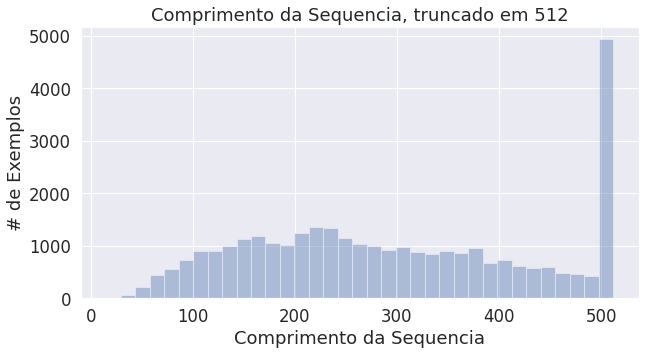

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

trunc_lengths = [min(l, 512) for l in lengths]

sns.distplot(trunc_lengths, kde=False, rug=False)

plt.title('Comprimento da Sequencia, truncado em 512')
plt.xlabel('Comprimento da Sequencia')
plt.ylabel('# de Exemplos')
plt.show()

In [ ]:
lengths = np.asarray(lengths)

num_comments = len(lengths)
max_lens = [128, 256, 300, 384, 512]

print('Quantas entradas serão truncadas?\n')

for max_len in max_lens:
    num_over = np.sum(lengths > max_len)
    prcnt_over = float(num_over) / float(num_comments)
    print(f'max_len = {max_len:} --> {num_over:>4,} de' \
    f'{num_comments:>4,}  ({prcnt_over:>5.1%}) serão truncadas')

Quantas entradas serão truncadas?

max_len = 128 --> 28,379 de32,187  (88.2%) serão truncadas
max_len = 256 --> 17,910 de32,187  (55.6%) serão truncadas
max_len = 300 --> 14,851 de32,187  (46.1%) serão truncadas
max_len = 384 --> 9,518 de32,187  (29.6%) serão truncadas
max_len = 512 --> 4,564 de32,187  (14.2%) serão truncadas


In [9]:
def sentinela_mask(contexto, label, pos_label):
    """
    Para nos ajudar a determinar quais tokens de BERT correspondem à resposta,
    substituiremos a resposta por "[MASK] [MASK] [MASK]" (com base em
    o número de tokens na resposta)
    """
    
    start_char_i = pos_label[0] # inicio da resposta
    end_char_i = pos_label[1]   # fim da resposta

    # Tokenize a resposta - ela pode ser dividida em várias palavras e / ou subpalavras
    answer_tokens = tokenizer.tokenize(label)
    
    # Crie a string sentinela, por exemplo, "[MASK] [MASK] [MASK]"
    sentinel_str = ' '.join(['[MASK]']*len(answer_tokens))

    # Para fazer a substituição, usamos  slice com concatenação de strings
    context_w_sentinel = contexto[:start_char_i] + sentinel_str + contexto[end_char_i:]

    return answer_tokens, context_w_sentinel 

#-------------------------------------------------------
contexto_ = df_qa_train.Context.to_list()[2]
label = df_qa_train.Answer.to_list()[2]
pos_label = df_qa_train.Pos_label.to_list()[2]

a, c = sentinela_mask(contexto_, label, pos_label)
c

'b&w brown & williamson tobacco corporation research & development . . . . internal correspondence to: r. h. honeycutt cc: [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] from: c. j. cook date: may 8. 1995 subject: review of existing brainstorming ideas/483 the major function of the product innovation group is to develop marketable novel products that would be profitable to manufacture and sell. novel is defined as: of a new kind, or different from anything seen or known before. innovation is defined as: something new or different introduced; act of innovating; introduction of new things or methods. the products may ncorporate the latest technologies, materials and know-how available to give then a unique taste or look. the first task of the product innovation group was to assemble, review and categorize a list of existing brainstorming ideas. ideas were grouped into two major categories labeled appearance and taste/aroma. these categories are used for novel products that may differ f

In [11]:
MAX_LEN=450

def tokenize_data(question_list, context_list, answer_list, pos_label_list, max_len=MAX_LEN):

    all_input_ids, attention_masks, segment_ids, start_positions = [], [], [], []
    end_positions, all_questions, all_answers, all_contexts = [], [], [], []
    num_dropped = 0

    for i, (question, answer, pos, context) in enumerate(
        zip(question_list, answer_list, pos_label_list, context_list)):

        answer_tokens, context_w_sentinel = sentinela_mask(context, answer, pos)

        encoded_dict = tokenizer.encode_plus(
            question, 
            context_w_sentinel,
            add_special_tokens = True,    # Add '[CLS]' e '[SEP]'
            max_length = max_len,         # Pad & trunca todas as sentenças
            pad_to_max_length = True,
            padding='max_length',
            truncation = True,
            return_attention_mask = True, # Constrói as attention masks
            return_tensors = 'pt',        # Retorna tensores de PyTorch
        )

        input_ids = encoded_dict['input_ids']

        is_mask_token = (input_ids[0] == tokenizer.mask_token_id)

        mask_token_indeces = is_mask_token.nonzero(as_tuple=False)[:, 0]

        # Se o número de tokens MASK não é igual ao número de tokens de resposta, 
        # então a amostra foi perdida devido ao truncamento
        if not len(mask_token_indeces) == len(answer_tokens):
            
            # Calcule o número de amostras com esse problema
            num_dropped += 1
            continue

        # anexa a pergunta, contexto e resposta
        all_questions.append(question)
        all_contexts.append(context)
        all_answers.append(answer)

        # `mask_token_indeces` é o intervalo de índices (por exemplo, [68, 69, 70, 71]),
        #  mas nós realmente queremos apenas os índices de início e fim (por exemplo, 68 e 71).
        start_index = mask_token_indeces[0]
        end_index = mask_token_indeces[-1]
        
        # Codifica os tokens de resposta (para ids de token).
        answer_token_ids = tokenizer.encode(answer_tokens, 
                                            add_special_tokens=False, 
                                            return_tensors='pt')

        # Restaure a resposta dentro do texto de referência. (Substitua os tokens `[MASK]`
        # com os tokens de resposta)
        input_ids[0, start_index : end_index + 1] = answer_token_ids

        # Adicione a frase codificada à lista
        all_input_ids.append(input_ids)

        # E sua máscara de atenção (simplesmente diferencia o padding do não padding)
        attention_masks.append(encoded_dict['attention_mask'])    

        # Armazene os IDs de segmento, que indicam quais tokens pertencem à pergunta
        # vs. o contexto
        segment_ids.append(encoded_dict['token_type_ids'])

        # Armazene os índices de início e fim da resposta correta
        start_positions.append(start_index)
        end_positions.append(end_index)

    all_input_ids = torch.cat(all_input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    segment_ids = torch.cat(segment_ids, dim=0)

    start_positions = torch.tensor(start_positions)
    end_positions = torch.tensor(end_positions)

    assert len(all_questions) == len(all_contexts) == len(all_answers)
    sentence_idx = np.linspace(0,len(all_questions), len(all_questions), False, dtype=np.int16)
    torch_idx = torch.tensor(sentence_idx)

    return torch_idx, all_questions, all_contexts, all_answers, all_input_ids, attention_masks, segment_ids, start_positions, end_positions

#----------------------------------------------------------------------------------
question_list_val = df_qa_val.Question.to_list()
context_list_val = df_qa_val.Context.to_list()
answer_list_val = df_qa_val.Answer.to_list()
pos_label_list_val = df_qa_val.Pos_label.to_list()

torch_idx, all_questions, all_contexts, all_answers, all_input_ids, attention_masks, segment_ids, start_positions, end_positions = \
tokenize_data(question_list_val, context_list_val, answer_list_val, pos_label_list_val, max_len=MAX_LEN)

print(f'Número de exemplos após o processamento: {len(all_input_ids)}')

In [12]:
%%time

#--------------------------------------- Train and Debug
question_list_train = df_qa_train.Question.to_list()
context_list_train = df_qa_train.Context.to_list()
answer_list_train = df_qa_train.Answer.to_list()
pos_label_list_train = df_qa_train.Pos_label.to_list()

torch_idx_train, all_questions_train, all_contexts_train, all_answers_train, all_input_ids_train, attention_masks_train, segment_ids_train, start_positions_train, end_positions_train = \
tokenize_data(question_list_train, context_list_train, answer_list_train, pos_label_list_train, max_len=MAX_LEN)

ds_train_p = TensorDataset(
    torch_idx_train,
    all_input_ids_train, 
    attention_masks_train, 
    segment_ids_train, 
    start_positions_train, 
    end_positions_train
    )

train_size = int(0.98 * len(ds_train_p))
debug_size   = len(ds_train_p) - train_size

# Divide o dataset e seleciona exemplos randomicamente
ds_train, ds_debug = random_split(ds_train_p, [train_size, debug_size])

len(ds_train_p), len(ds_debug)

#--------------------------------------- Val
question_list_val = df_qa_val.Question.to_list()
context_list_val = df_qa_val.Context.to_list()
answer_list_val = df_qa_val.Answer.to_list()
pos_label_list_val = df_qa_val.Pos_label.to_list()

torch_idx_val, all_questions_val, all_contexts_val, all_answers_val, all_input_ids_val, attention_masks_val, segment_ids_val, start_positions_val, end_positions_val = \
tokenize_data(question_list_val, context_list_val, answer_list_val, pos_label_list_val, max_len=MAX_LEN)

ds_val = TensorDataset(
    torch_idx_val,
    all_input_ids_val, 
    attention_masks_val, 
    segment_ids_val, 
    start_positions_val, 
    end_positions_val
    )

CPU times: user 3min 13s, sys: 588 ms, total: 3min 14s
Wall time: 3min 14s


In [13]:
BATCH_SZ = 4

# dataloaders
dataloaders = {
     'debug': DataLoader(
         ds_debug,
         batch_size=BATCH_SZ,
         num_workers=os.cpu_count(),
         pin_memory=True
         ),
     
     'train': DataLoader(
         ds_train,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=os.cpu_count(),
         pin_memory=True
         ),
               
     'val': DataLoader(
         ds_val,
         batch_size=BATCH_SZ,
         num_workers=os.cpu_count(),
         pin_memory=True
         ),
     }

# teste de sanidade
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}
dl_sizes 

{'debug': 157, 'train': 7661, 'val': 1053}

In [51]:
# =========================== #
# === Teste do Dataloader === #
# =========================== #
 
torch_idx, input_ids, attention_masks, segment_ids, start_positions, end_positions = next(iter(dataloaders['val']))
 
print('torch_idx.shape:       ', torch_idx.shape)
print('input_ids.shape:       ', input_ids.shape)
print('attention_masks.shape: ', attention_masks.shape)
print('segment_ids.shape:     ', segment_ids.shape)
print('start_positions.shape: ', start_positions.shape)
print('end_positions.shape:   ', end_positions.shape)

torch_idx.shape:        torch.Size([4])
input_ids.shape:        torch.Size([4, 450])
attention_masks.shape:  torch.Size([4, 450])
segment_ids.shape:      torch.Size([4, 450])
start_positions.shape:  torch.Size([4])
end_positions.shape:    torch.Size([4])


In [82]:
def train_model(model, device, train_loader, optimizer):
    num_batches = len(train_loader)    
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_loader):
        batch_device = tuple(t.to(device) if type(t) != list else t for t in batch)
        b_torch_idx, b_input_ids, b_input_mask, b_seg_ids, answer_true_start, answer_true_end = batch_device
        
        model.zero_grad()        
        outputs = model(
            b_input_ids, 
            attention_mask=b_input_mask, 
            token_type_ids = b_seg_ids,
            start_positions=answer_true_start,
            end_positions=answer_true_end
            )

        (loss, start_logits, end_logits) = outputs
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        avg_train_loss = total_train_loss / len(train_loader)            

    return avg_train_loss

def answer_question(model, question, answer_text, max_len=MAX_LEN):
    '''
    Toma uma string `pergunta` e uma string `texto que contém a resposta`, e 
    identifica as palavras dentro do `answer_text` que são a resposta. 
    '''
    input_ids = tokenizer.encode(
        question, 
        answer_text,
        truncation=True,
        )
    sep_index = input_ids.index(tokenizer.sep_token_id)

    num_seg_a = sep_index + 1
    num_seg_b = len(input_ids) - num_seg_a
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    assert len(segment_ids) == len(input_ids)

    start_scores, end_scores = model(
        torch.tensor([input_ids]).to(device), 
        token_type_ids=torch.tensor([segment_ids]).to(device))

    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer = tokens[answer_start]

    for i in range(answer_start + 1, answer_end + 1):
        
        # Se é um token de subword, então recombina com o token anterior.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Se não, adiciona um espaço ao token.
        else:
            answer += ' ' + tokens[i]
    return answer

def get_score(model, questions, contexts, answers, answer_question, compute_f1, compute_exact):
    size = len(answers)
    f1_result, exact_result = 0,0
    for index in range(size):
        pred = answer_question(model, questions[index], contexts[index])
        true = answers[index]
        f1_result += compute_f1(true, pred)
        exact_result += compute_exact(true, pred)
    return f1_result/size, exact_result/size

In [83]:
# ================ #
# === Métricas === #
# ================ #
 
path_save_model = '/content/drive/MyDrive/Colab Notebooks/Final-project/saved_epochs/'

def normalize_answer(s):
    def white_space_fix(text):
        return ' '.join(text.split())
 
    def lower(text):
        return text.lower()
 
    return white_space_fix(lower(s))
 
def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()
 
def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))
 
def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
deterministic()
N_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

model = BertForQuestionAnswering.from_pretrained(
    'bert-large-uncased-whole-word-masking-finetuned-squad', 
    ).to(device)


#----------------------------------------------------------------
training_stats = []
for epoch_i in range(1, N_EPOCHS+1):
    loss_train = train_model(model, device, dataloaders['train'], optimizer)
    print(f'\nEpoca [{epoch_i}/{N_EPOCHS}]: Loss Train: {loss_train:.3f}')
    
    f1_result, exact_result = get_score(model, all_questions_val, all_contexts_val, all_answers_val, 
                                        answer_question, compute_f1, compute_exact)  
    print(f'           Exact Match: {exact_result:.4f} -- F1: {f1_result:.4}')

    training_stats.append({'epoch': epoch_i, 'Training Loss': loss_train, 'Exact': exact_result, 'F1': f1_result})

Experimento deterministico, seed: 2357 -- Existe 1 GPU Tesla V100-SXM2-16GB disponível.


In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
pd.set_option('precision', 2)
df_stats

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()